# CSC3160 Assignment 1
Name: Xu Kai \
Student ID: 121090650

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

### Question 1: Extract MFCCs
Here I define n_mfcc=12,so each frame there will exist 12 MFCC coefficients

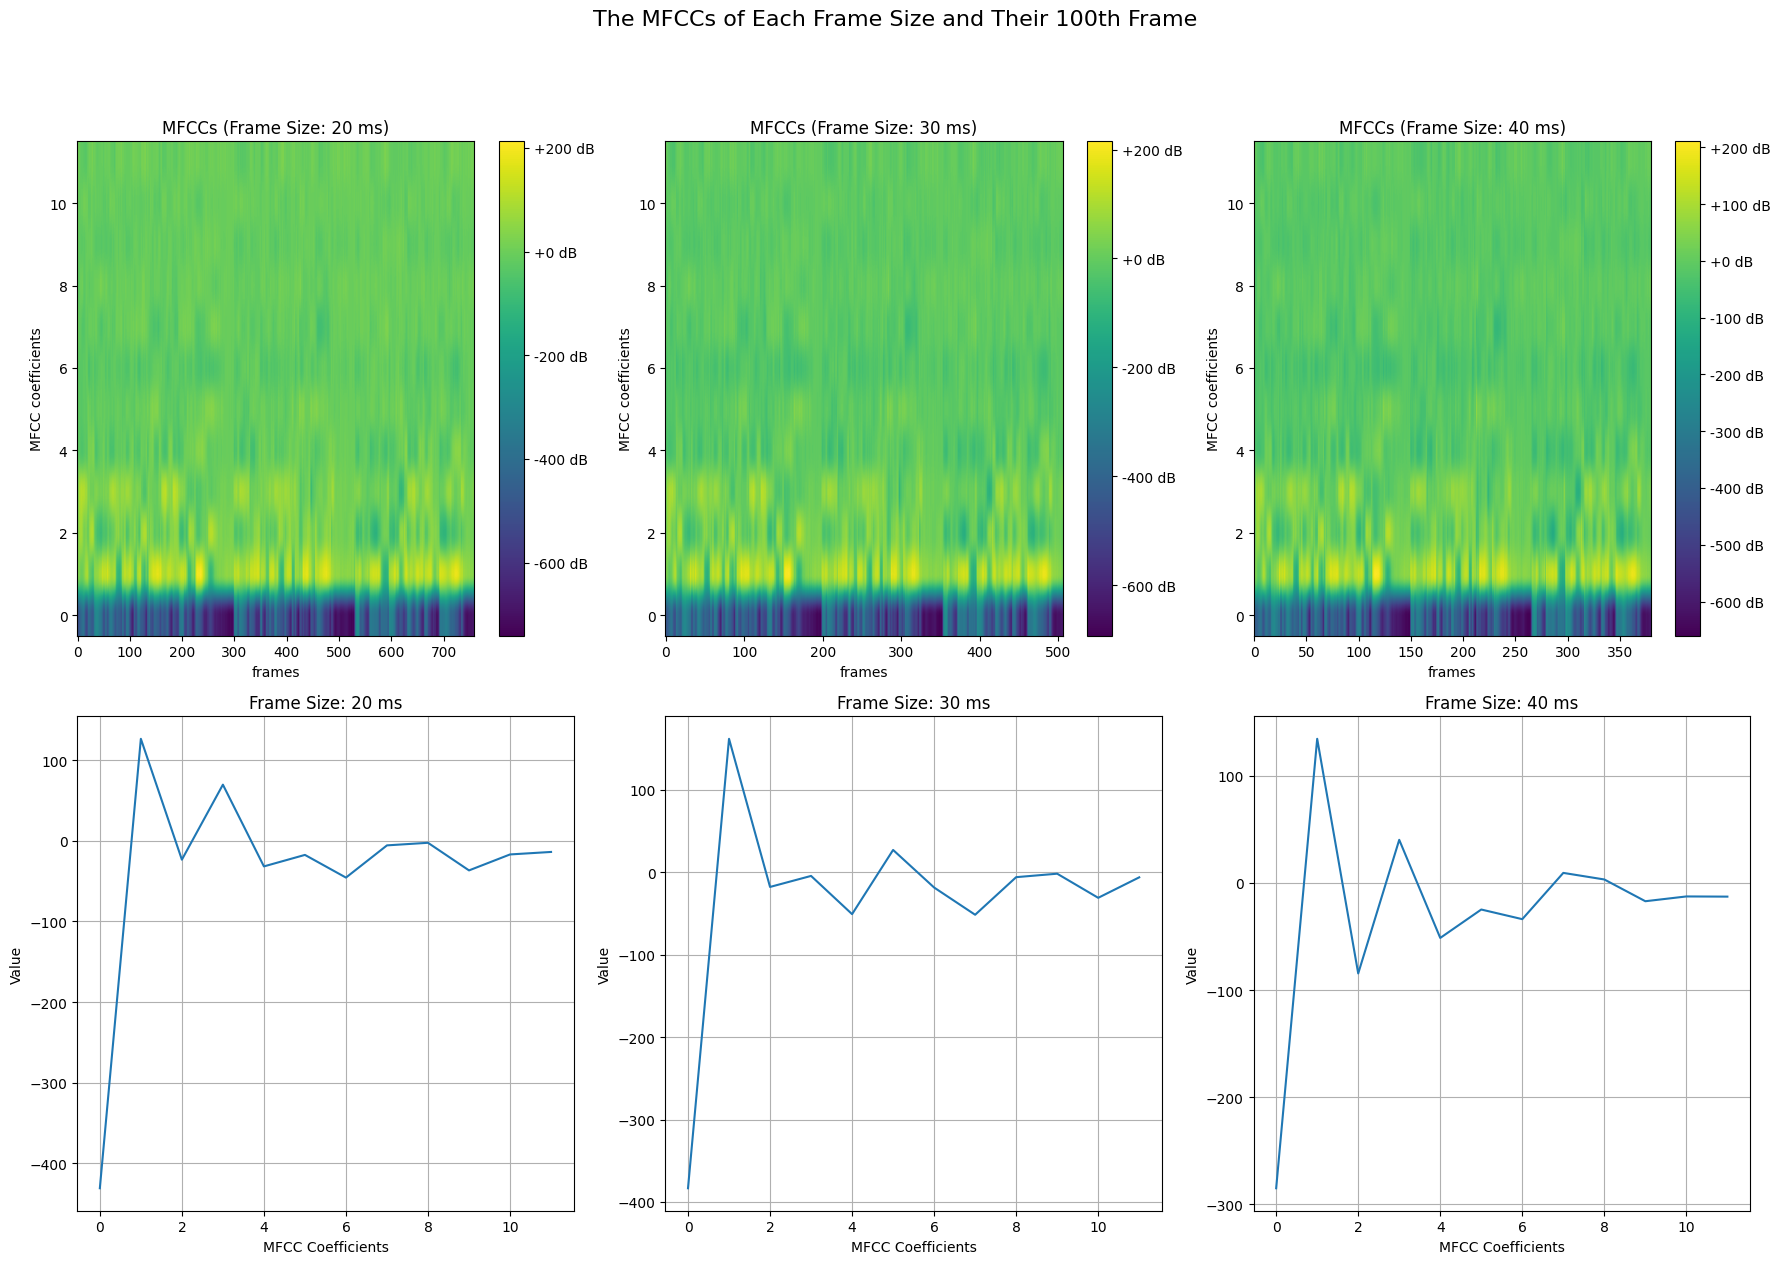

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_path = 'reference.wav'
y, sr = librosa.load(audio_path, sr=16000)

# Define frame sizes in seconds
frame_sizes = [0.02, 0.03, 0.04]  # 20ms, 30ms, 40ms
mfccs = []

# Extract MFCCs for each frame size
for frame_size in frame_sizes:
    win_length = int(sr * frame_size)
    hop_length = win_length // 2  # 50% overlap
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, n_fft=win_length, hop_length=hop_length)
    mfccs.append(mfcc)

# Create a figure with 2 rows and 3 columns
plt.figure(figsize=(18, 12))

# Plot the MFCCs of the 100th frame for each frame size in a 2x3 grid
for i, (mfcc, size) in enumerate(zip(mfccs, frame_sizes)):
    if mfcc.shape[1] > 99:  # Ensure the 100th frame exists
        plt.subplot(2, 3, i + 1)
        plt.imshow(mfcc, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel('frames')
        plt.ylabel('MFCC coefficients')
        plt.title(f'MFCCs (Frame Size: {int(size*1000)} ms)')

# Plot the MFCCs of the 100th frame for each frame size
for i, (frame_size, mfcc) in enumerate(zip(frame_sizes, mfccs)):
    if mfcc.shape[1] > 99:  # Ensure there are at least 100 frames
        plt.subplot(2, 3, i + 4)  # Start from the 4th subplot
        plt.plot(mfcc[:, 99])  # 100th frame (index 99)
        plt.title(f'Frame Size: {int(frame_size * 1000)} ms')
        plt.xlabel('MFCC Coefficients')
        plt.ylabel('Value')
        plt.grid()

# Add a main title
plt.suptitle('The MFCCs of Each Frame Size and Their 100th Frame', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

### Question 2:Record myself
In this part I use `librosa` and `soundfile` to resample my recording to 16 kHz and 24-bit depth.

In [3]:
import soundfile as sf

# Set the target sample rate
fs = 16000

# Load the audio file and resample to 16 kHz
x, _ = librosa.load("./myspeech.m4a", sr=fs)

# Save the audio as a 24-bit depth WAV file
sf.write("./myspeech_16k_24bit.wav", x, fs, subtype='PCM_24')

# Verify the file information
info = sf.info("./myspeech_16k_24bit.wav")
print(info)

./myspeech_16k_24bit.wav
samplerate: 16000 Hz
channels: 1
duration: 12.480 s
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]


### Question 3:Pitch Estimation

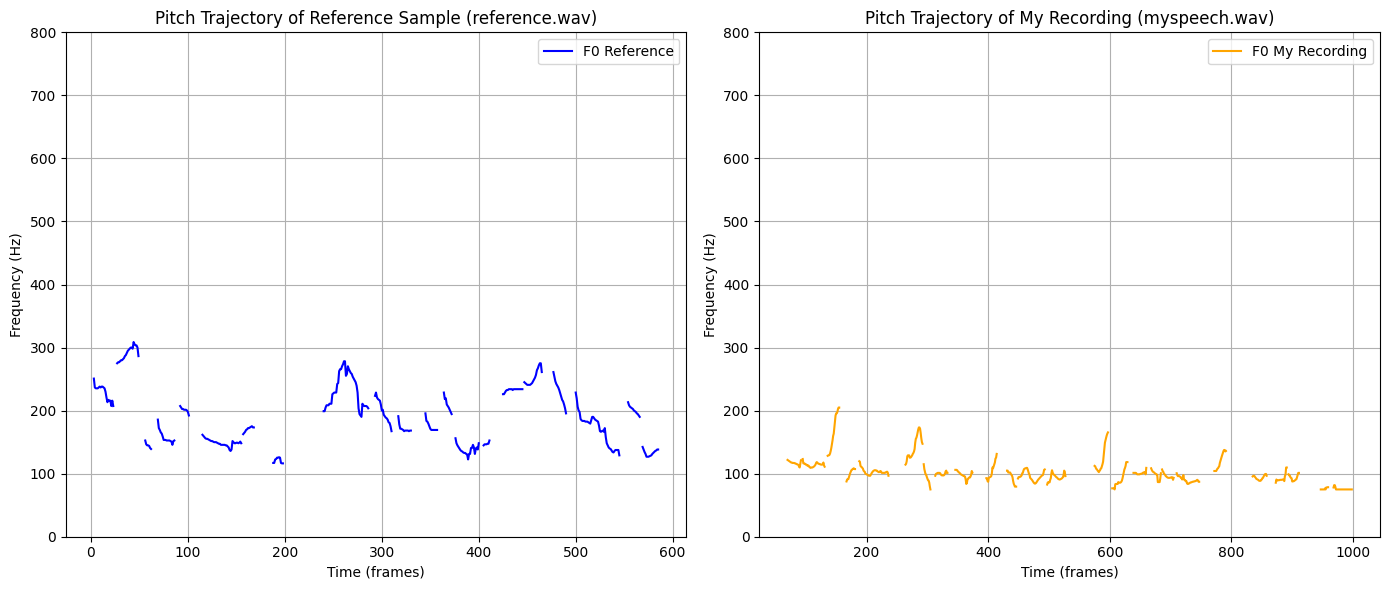

In [4]:
# Set the sample rate and hop length
sample_rate = 16000
hop_length = 200

# Load the reference speech sample
reference_audio_path = 'reference.wav'
y_ref, sr_ref = librosa.load(reference_audio_path, sr=sample_rate)

# Extract the fundamental frequency (F0) using the YIN algorithm
f0_ref, voiced_flag_ref, _ = librosa.pyin(y_ref, fmin=75, fmax=800, sr=sample_rate, hop_length=hop_length)

# Load your own recording
my_audio_path = 'myspeech_16k_24bit.wav'
y_my, sr_my = librosa.load(my_audio_path, sr = sample_rate)

# Extract the fundamental frequency (F0) using the YIN algorithm
f0_my, voiced_flag_my, _ = librosa.pyin(y_my, fmin=75, fmax=800, sr=sample_rate, hop_length=hop_length)

# Plot the pitch trajectories
plt.figure(figsize=(14, 6))  # Adjusting the figure size

# Plot the pitch trajectory of the reference sample
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(f0_ref, label='F0 Reference', color='blue')
plt.title('Pitch Trajectory of Reference Sample (reference.wav)')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 800)  # Set the y-axis range
plt.legend()
plt.grid()

# Plot the pitch trajectory of your own recording
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(f0_my, label='F0 My Recording', color='orange')
plt.title('Pitch Trajectory of My Recording (myspeech.wav)')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 800)  # Set the y-axis range
plt.legend()
plt.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Question 4 Dynamic Time Warping

#### 4.1 Visualize the aligned mel-spectrograms of the reference speech and your recording

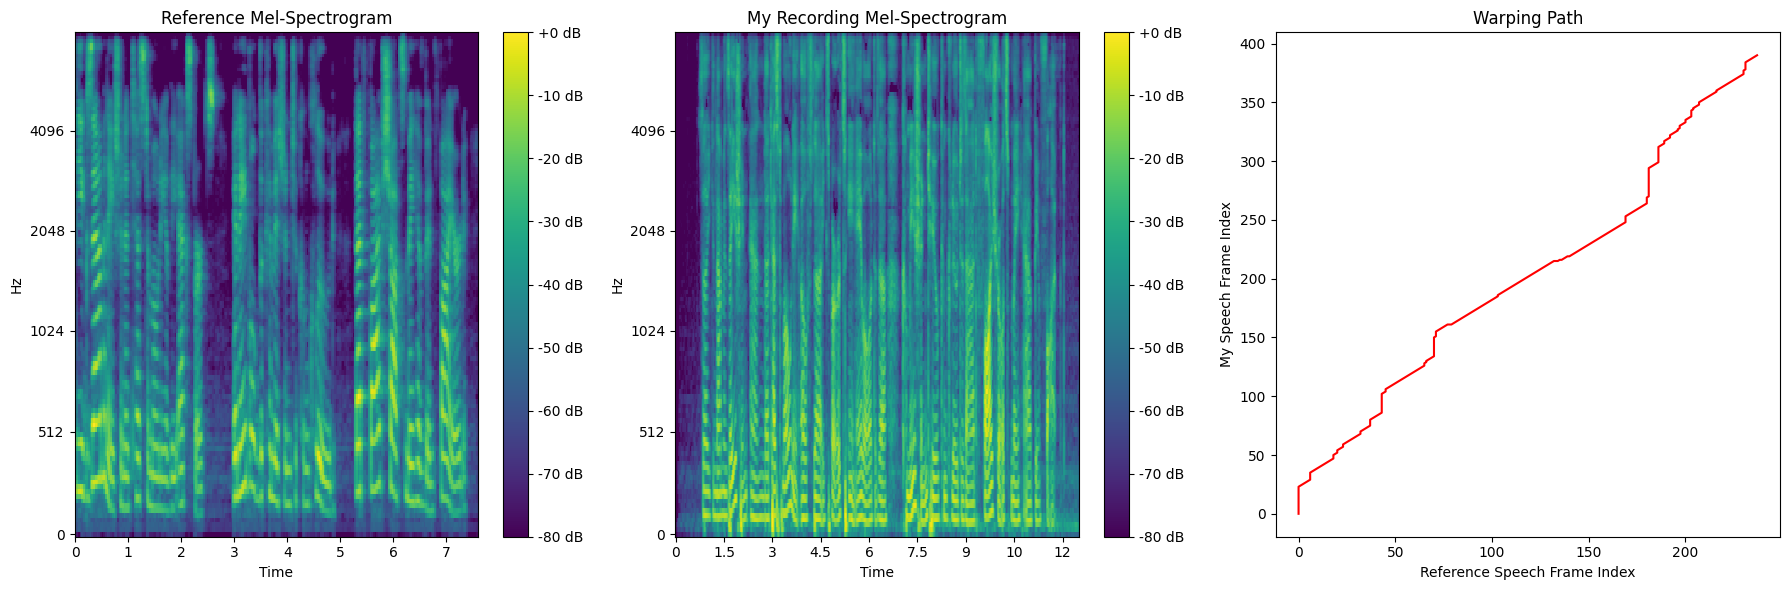

The distance between the mel-spe of my speech and reference speech is 72057.20675422692


In [15]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Load the reference and recording audio
reference_audio_path = 'reference.wav'
my_audio_path = 'myspeech_16k_24bit.wav'

y_ref, sr_ref = librosa.load(reference_audio_path, sr=16000)
y_my, sr_my = librosa.load(my_audio_path, sr=16000)

# Parameters for mel-spectrogram
n_mels = 128
n_fft = 2048
hop_length = 512

# Compute mel-spectrograms
mel_spec_ref = librosa.feature.melspectrogram(y=y_ref, sr=sr_ref, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
mel_spec_my = librosa.feature.melspectrogram(y=y_my, sr=sr_my, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)

# Convert to log scale
log_mel_spec_ref = librosa.power_to_db(mel_spec_ref, ref=np.max)
log_mel_spec_my = librosa.power_to_db(mel_spec_my, ref=np.max)

# Perform DTW
distance, path = fastdtw(log_mel_spec_ref.T, log_mel_spec_my.T, dist=euclidean)

# Extract the warping path
warp_path = np.array(path)

# Plotting aligned mel-spectrograms and warping path
plt.figure(figsize=(18, 6))

# Plot the mel-spectrogram of the reference sample
plt.subplot(1, 3, 1)
librosa.display.specshow(log_mel_spec_ref, sr=sr_ref, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.title('Reference Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot the mel-spectrogram of your own recording
plt.subplot(1, 3, 2)
librosa.display.specshow(log_mel_spec_my, sr=sr_my, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.title('My Recording Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Plot the warping path
plt.subplot(1, 3, 3)
plt.plot(warp_path[:, 0], warp_path[:, 1], color='r')
plt.title("Warping Path")
plt.xlabel("Reference Speech Frame Index")
plt.ylabel("My Speech Frame Index")

plt.tight_layout()
plt.show()

print(f"The distance between the mel-spe of my speech and reference speech is {distance}")

#### 4.2 Obtain the time stamp of the word “Commission” in your recording
- **Step 1 Identify Reference Time Frame**: Already know that "Commission" is spoken in the reference audio (reference.wav) from 3.6s to 4.1s.
  Calculate the corresponding frame indices for these timestamps based on the hop_length used when computing the mel-spectrogram.
- **Step 2 Use DTW Path**:The DTW algorithm provides a path that maps frames from the reference audio to frames of my recording.
  Extract the corresponding frames for the reference segment from the warping path.
- **Step 3 Calculate Time Stamps**:Use the frame indices from the DTW path to calculate the corresponding time stamps in my recording.
- **Step 4 Determine the Start and End Time**

In [16]:
# step 1
start_time_ref = 3.6  # start time in seconds
end_time_ref = 4.1    # end time in seconds
start_frame_ref = int(start_time_ref * sr_ref / hop_length)
end_frame_ref = int(end_time_ref * sr_ref / hop_length)
# ------------------------------------------
# step 2
warp_path = np.array(path)  # Assuming path is the output from DTW
corresponding_frames = warp_path[(warp_path[:, 0] >= start_frame_ref) & (warp_path[:, 0] <= end_frame_ref)]
# ------------------------------------------
#step 3
# Extract the frame indices for your recording
my_speech_frames = corresponding_frames[:, 1]

# Calculate the time stamps in your recording
time_stamps_my_speech = my_speech_frames * hop_length / sr_my
# ------------------------------------------
# step 4
start_time_my_speech = np.min(time_stamps_my_speech)
end_time_my_speech = np.max(time_stamps_my_speech)

print(f"The time stamp is [{start_time_my_speech},{end_time_my_speech}]")

The time stamp is [6.24,6.752]
